In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "1"
os.environ["JAX_NUM_CPU_DEVICES"] = "4"

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import jax.numpy as jnp
import bambi as bmb

az.style.use("arviz-darkgrid")
SEED = 3990


In [2]:
pokemon_df = pl.read_csv("./data/Pokemon.csv")
typing = ["Type 1", "Type 2"]
ability = ["HP", "Attack", "Defense", "Sp.Atk", "Sp.Def", "Speed"]

In [3]:
old_col = [
    'HP', 'Attack', 'Defense',
    'Sp.Atk', 'Sp.Def', 'Speed'
]

new_col = [
        'clr_HP', 'clr_Attack', 'clr_Defense',
        'clr_SpAtk', 'clr_SpDef', 'clr_Speed'
    ]


closed_pokemon_df = pokemon_df.with_columns(
    pl.col(old_col) / pl.col("Total")
)

closed_pokemon_df.shape

(800, 13)

In [4]:
# columns = [HP, Attack, Defense, SpAtk, SpDef, Speed]
contrast_matrix = [
    ([5],    [2]),           # B1: {Speed} vs {Defense}
    ([1], [3, 4]),           # B2: {Attack} vs {SpAtk, SpDef}
    ([0], [2, 4]),           # B3: {HP} vs {Defense, SpDef}
    ([3], [0, 5]),           # B4: {SpAtk} vs {HP, Speed}
    ([1, 4], [2]),           # B5: {Attack, SpDef} vs {Defense}
]

def ilr_from_sbp(X, sbp):
    """
    X: (n, D) compositions (rows sum to 1; strictly >0)
    sbp: list of (pos_idx, neg_idx) index lists
    returns Z: (n, D-1) ILR balances
    """
    Z = []
    logX = np.log(X)
    for pos, neg in sbp:
        r, s = len(pos), len(neg)
        gm_pos = np.exp(logX[:, pos].mean(axis=1))
        gm_neg = np.exp(logX[:, neg].mean(axis=1))
        coef = np.sqrt((r * s) / (r + s))
        Z.append(coef * (np.log(gm_pos) - np.log(gm_neg)))
    return np.column_stack(Z)


In [5]:
ilr_df = ilr_from_sbp(closed_pokemon_df[old_col].to_numpy(), contrast_matrix)

In [6]:
unique_typing = set(pokemon_df["Type 1"].unique().to_list() + pokemon_df["Type 2"].unique().to_list()) - set([None])

pokemon_df = pokemon_df.with_columns(
    pl.concat_list([pl.col("Type 1"), pl.col("Type 2")])
    .list.drop_nulls()
    .list.sort()
    .list.join(", ")
    .alias("CombinedTyping")
)
pokemon_df.head()

combined_typing = pokemon_df["CombinedTyping"].unique().to_list()
pokemon_df.head()

#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,Generation,Legendary,CombinedTyping
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,bool,str
1,"""Bulbasaur""","""Grass""","""Poison""",318,45,49,49,65,65,45,1,false,"""Grass, Poison"""
2,"""Ivysaur""","""Grass""","""Poison""",405,60,62,63,80,80,60,1,false,"""Grass, Poison"""
3,"""Venusaur""","""Grass""","""Poison""",525,80,82,83,100,100,80,1,false,"""Grass, Poison"""
3,"""VenusaurMega Venusaur""","""Grass""","""Poison""",625,80,100,123,122,120,80,1,false,"""Grass, Poison"""
4,"""Charmander""","""Fire""",null,309,39,52,43,60,50,65,1,false,"""Fire"""


In [7]:
# Dimension ILR 1
model_df = pd.DataFrame({
        "B1": ilr_df[:, 0],
        "B2": ilr_df[:, 1],
        "B3": ilr_df[:, 2],
        "B4": ilr_df[:, 3],
        "B5": ilr_df[:, 4],
        "Type 1": pokemon_df["Type 1"].to_list(),
        "Type 2": pokemon_df["Type 2"].to_list(),
        "CombinedTyping": pokemon_df["CombinedTyping"].to_list()
    })

model_df.head()

,B1,B2,B3,B4,B5,Type 1,Type 2,CombinedTyping
0,-0.060216,-0.230715,-0.184889,0.300246,0.115357,Grass,Poison,"Grass, Poison"
1,-0.034500,-0.208119,-0.137364,0.234891,0.090995,Grass,Poison,"Grass, Poison"
2,-0.026031,-0.162035,-0.106127,0.182196,0.071120,Grass,Poison,"Grass, Poison"
3,-0.304167,-0.155613,-0.341142,0.344557,-0.094594,Grass,Poison,"Grass, Poison"
4,0.292167,-0.042409,-0.141295,0.143189,0.139158,Fire,None,Fire


# Model 1: Balanced 1 ~ Primary Type 

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/techen/biosustain/course/bayesian_statistics/pokemon/.venv/lib/python3.12/site-packages/

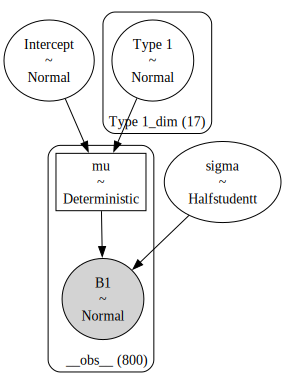

In [ ]:
model = bmb.Model(
    "B1 ~ 'Type 1'",
    data = model_df,
    family="gaussian" 
)
model.build()

model.graph()

In [29]:
idata = model.fit(
    draws = 2000,
    chains = 4,
    cores = 1,
    random_seed = SEED,
    backend = "jax"
)

az.summary(idata, var_names=["Type 1", "sigma"])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, Type 1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Type 1[Dark],0.198,0.090,0.026,0.361,0.001,0.001,4821.0,5460.0,1.0
Type 1[Dragon],0.121,0.089,-0.041,0.290,0.001,0.001,4344.0,5456.0,1.0
Type 1[Electric],0.336,0.080,0.180,0.482,0.001,0.001,4178.0,5564.0,1.0
Type 1[Fairy],-0.116,0.113,-0.331,0.097,0.001,0.001,6477.0,5409.0,1.0
Type 1[Fighting],0.126,0.095,-0.053,0.301,0.001,0.001,5015.0,5466.0,1.0
Type 1[Fire],0.199,0.076,0.055,0.343,0.001,0.001,3952.0,5352.0,1.0
Type 1[Flying],0.461,0.219,0.029,0.859,0.002,0.003,12077.0,5825.0,1.0
Type 1[Ghost],-0.030,0.090,-0.200,0.135,0.001,0.001,4838.0,5939.0,1.0
Type 1[Grass],0.015,0.071,-0.121,0.145,0.001,0.001,3540.0,5712.0,1.0
Type 1[Ground],-0.069,0.090,-0.236,0.101,0.001,0.001,4709.0,5830.0,1.0


In [30]:
print(idata.sample_stats.diverging.sum().item() > 0)
print(az.rhat(idata).to_array().max().item())

False
1.0027969391434484


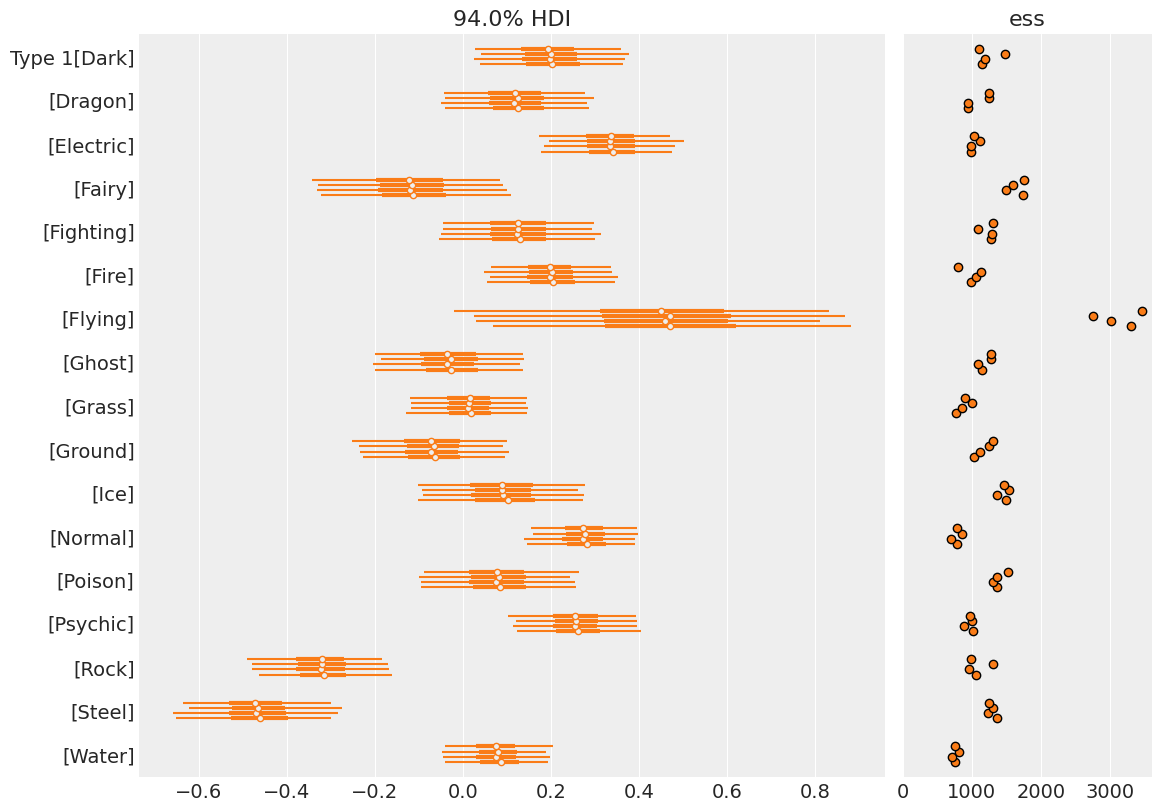

In [36]:
ax = az.plot_forest(
    idata,
    var_names=["Type 1"],
    figsize=(11.5, 8),
    colors="C1",
    ess=True,
)

plt.savefig("./result/forest_plot_type1.png", dpi=300, bbox_inches='tight')
plt.show()

array([[<Axes: title={'center': 'Type 1'}>,
        <Axes: title={'center': 'Type 1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

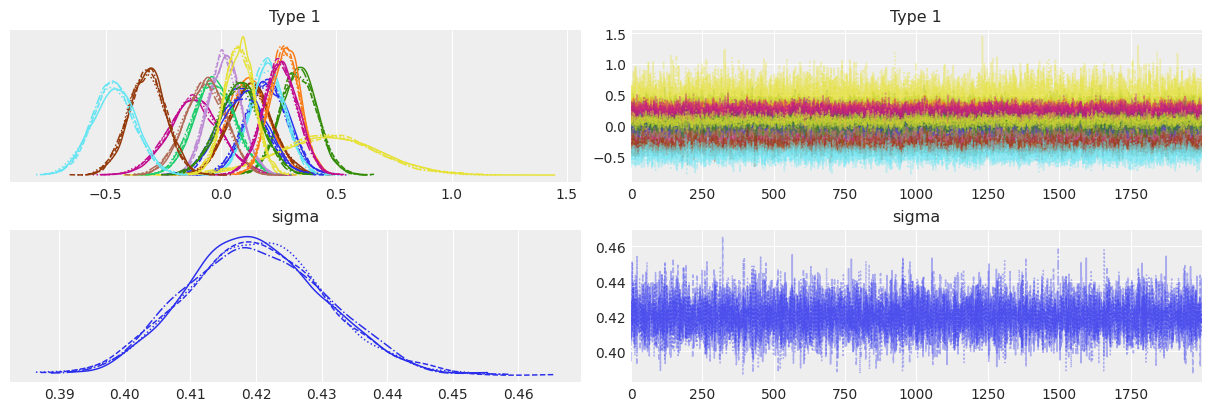

In [34]:
az.plot_trace(
    idata,
    var_names=["Type 1", "sigma"],
    compact=True,    
)

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Type 1\nDark'}>,
        <Axes: title={'center': 'Type 1\nDragon'}>],
       [<Axes: title={'center': 'Type 1\nElectric'}>,
        <Axes: title={'center': 'Type 1\nFairy'}>,
        <Axes: title={'center': 'Type 1\nFighting'}>,
        <Axes: title={'center': 'Type 1\nFire'}>],
       [<Axes: title={'center': 'Type 1\nFlying'}>,
        <Axes: title={'center': 'Type 1\nGhost'}>,
        <Axes: title={'center': 'Type 1\nGrass'}>,
        <Axes: title={'center': 'Type 1\nGround'}>],
       [<Axes: title={'center': 'Type 1\nIce'}>,
        <Axes: title={'center': 'Type 1\nNormal'}>,
        <Axes: title={'center': 'Type 1\nPoison'}>,
        <Axes: title={'center': 'Type 1\nPsychic'}>],
       [<Axes: title={'center': 'Type 1\nRock'}>,
        <Axes: title={'center': 'Type 1\nSteel'}>,
        <Axes: title={'center': 'Type 1\nWater'}>, <Axes: >]],
      dtype=object)

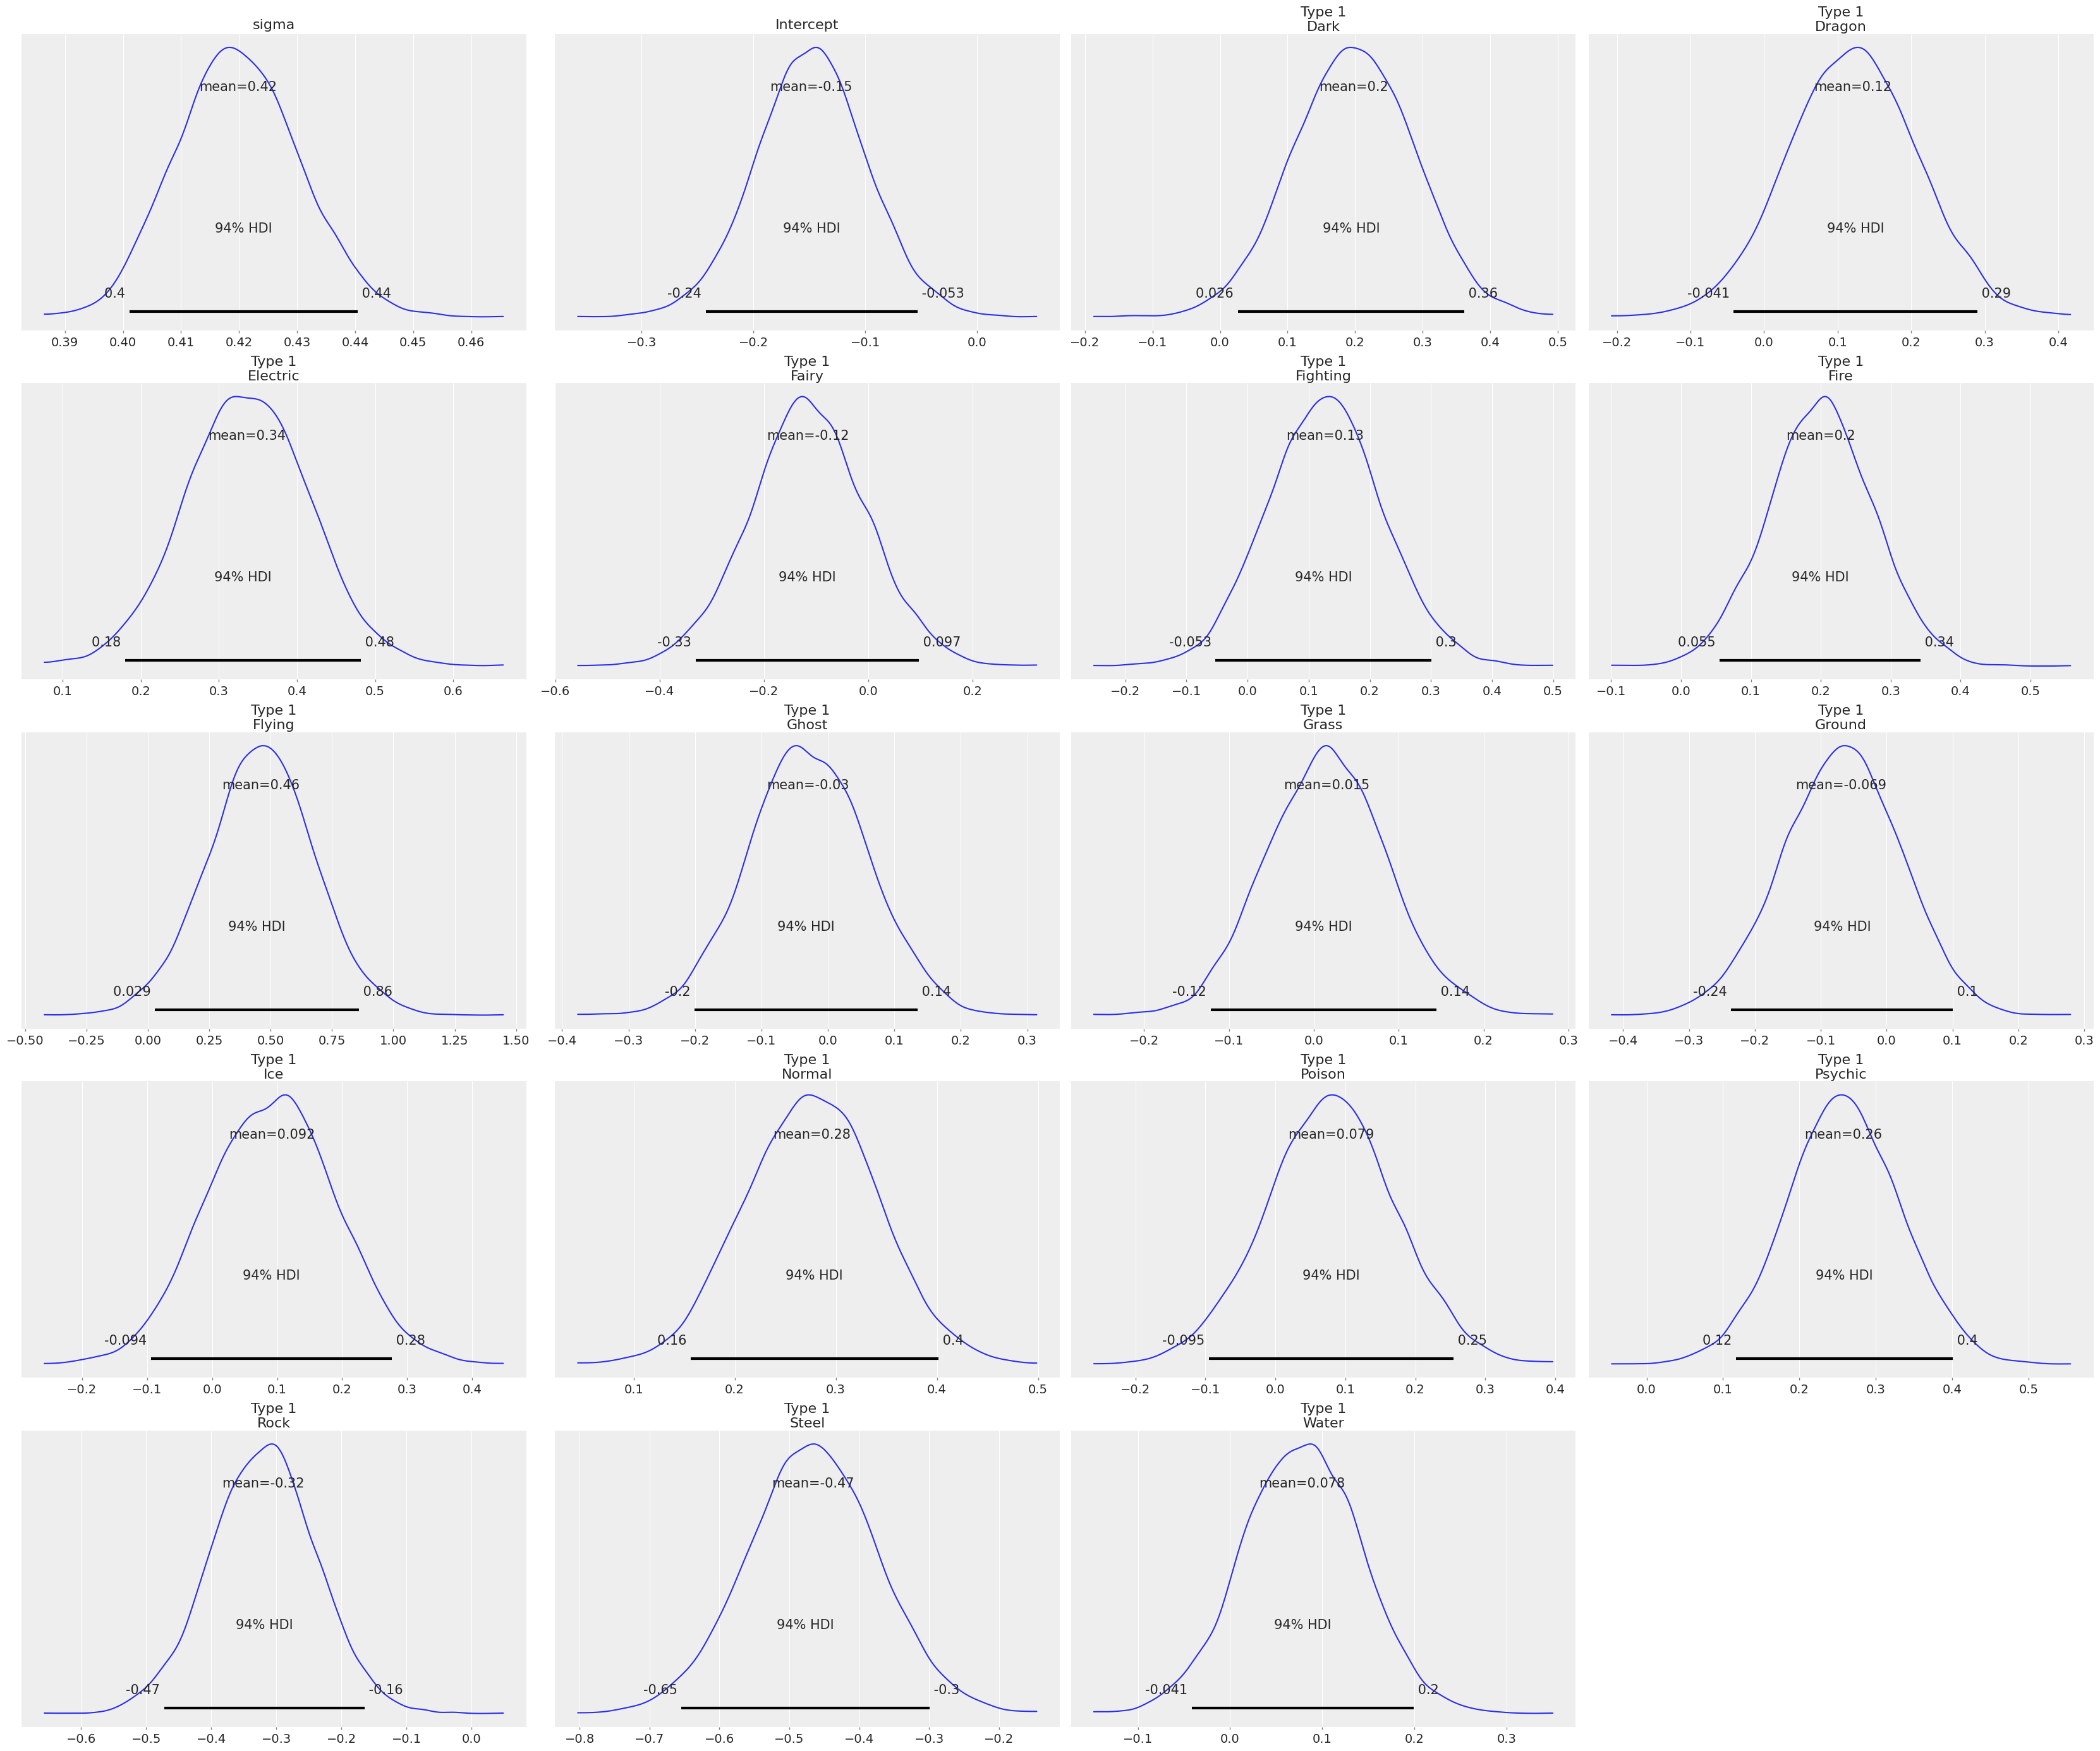

In [35]:
az.plot_posterior(idata)

# Model 2: Is Primary Type more important than Secondary Type?

In [46]:

model_df['Type 2'] = model_df['Type 2'].fillna('None')

balance_to_test = 'B1'

# Model 1: Primary type only
model_p = bmb.Model(f"{balance_to_test} ~ 'Type 1'", data=model_df)
results_p = model_p.fit(
        draws = 2000,
        chains = 4,
        random_seed = SEED,
        backend = "jax",
        idata_kwargs=dict(log_likelihood = True)
)

# Model 2: Secondary type only
model_s = bmb.Model(f"{balance_to_test} ~ 'Type 2'", data=model_df)
results_s = model_s.fit(
        draws = 2000,
        chains = 4,
        random_seed = SEED,
        backend = "jax",
        idata_kwargs=dict(log_likelihood = True)
)

# Model 3: Both types (additive)
model_b = bmb.Model(f"{balance_to_test} ~ 'Type 1' + 'Type 2'", data=model_df)
results_b = model_b.fit(
        draws = 2000,
        chains = 4,
        cores = 1,
        random_seed = SEED,
        backend = "jax",
        idata_kwargs=dict(log_likelihood = True)
    )



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Type 1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Type 2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, Type 1, Type 2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


In [59]:
results_p

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

                rank    elpd_loo      p_loo  elpd_diff    weight         se  \
Both Types         0 -403.970326  35.316435   0.000000  0.801988  27.327057   
Secondary Only     1 -447.753129  18.198178  43.782803  0.135650  26.215429   
Primary Only       2 -450.165103  18.511505  46.194778  0.062362  30.302049   

                      dse  warning scale  
Both Types       0.000000    False   log  
Secondary Only  11.413038    False   log  
Primary Only    12.699251    False   log  


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

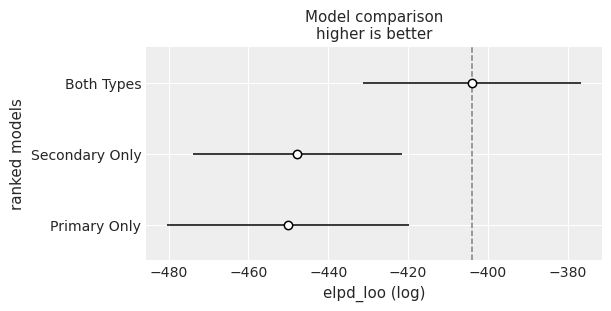

In [61]:
model_comparison = az.compare({
    'Primary Only': results_p, 
    'Secondary Only': results_s,
    'Both Types': results_b
})

# Display the comparison table
print(model_comparison)

az.plot_compare(model_comparison)

# Model 3: Balance 1-5 ~ Combined Type

In [17]:
models = {}
balances = ['B1', 'B2', 'B3', 'B4', 'B5']

for balance in balances:
    model = bmb.Model(
        f"{balance} ~ CombinedTyping", 
        data=model_df,
        family="gaussian"
    )
    models[balance] = model.fit(
        draws = 2000,
        chains = 4,
        cores = 1,
        random_seed = SEED,
        backend = "jax"
    )

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, CombinedTyping]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, CombinedTyping]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, CombinedTyping]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, CombinedTyping]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, Intercept, CombinedTyping]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


/var/folders/rm/0tp2_wjs4hl3t3t2bgrztxbr0000gp/T/ipykernel_54972/4230138447.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


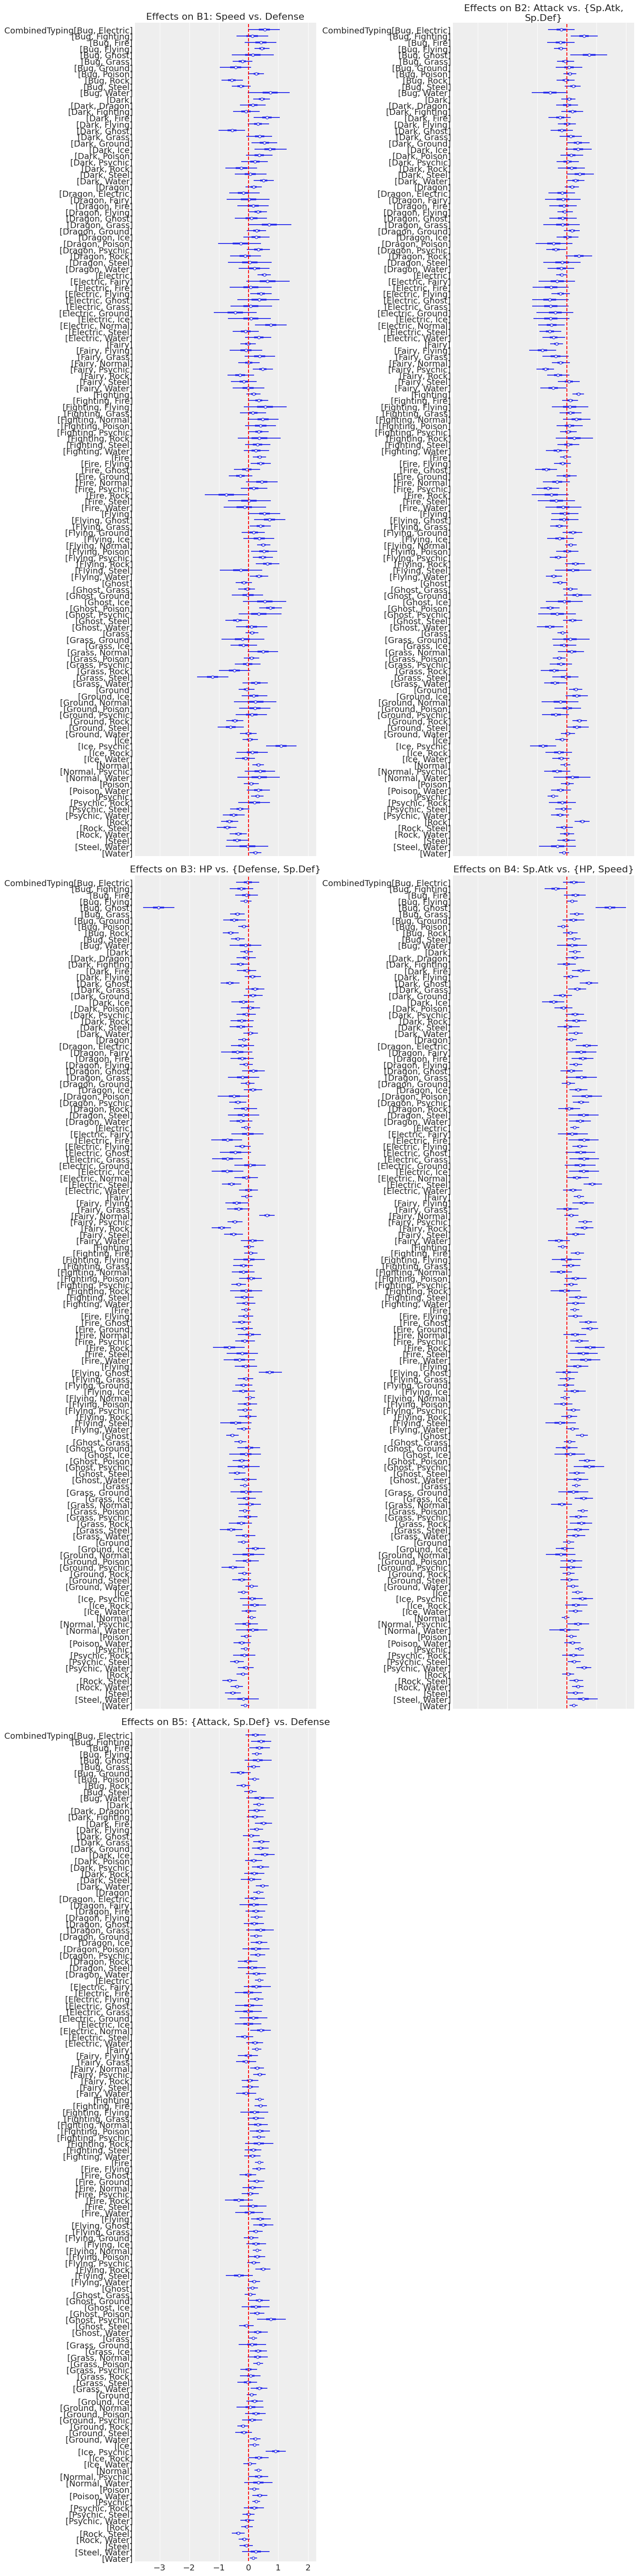

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 60), sharex=True)
axes = axes.ravel() 

balance_definitions = {
    'B1': "Speed vs. Defense",
    'B2': "Attack vs. {Sp.Atk, Sp.Def}",
    'B3': "HP vs. {Defense, Sp.Def}",
    'B4': "Sp.Atk vs. {HP, Speed}",
    'B5': "{Attack, Sp.Def} vs. Defense"
}

for i, balance in enumerate(balances):
    az.plot_forest(
        models[balance],
        var_names=["CombinedTyping"],
        combined=True,
        ax=axes[i],
    )
    axes[i].set_title(f"Effects on {balance}: {balance_definitions[balance]}")
    axes[i].vlines(0, -1, len(models[balance].posterior["CombinedTyping_dim"]), color='red', linestyle='--')

fig.delaxes(axes[5]) 
plt.tight_layout()
plt.show()

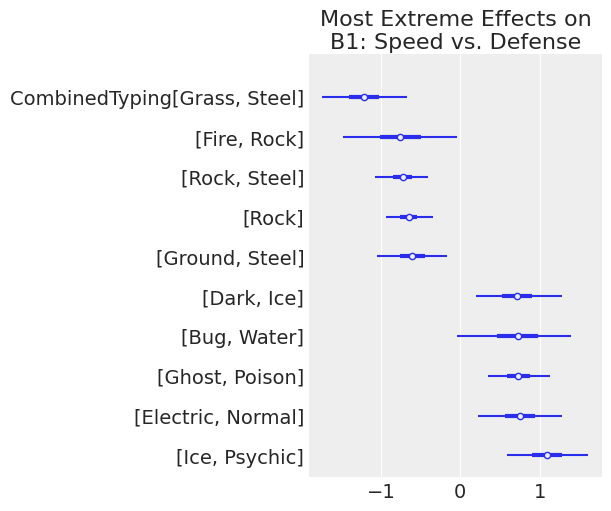

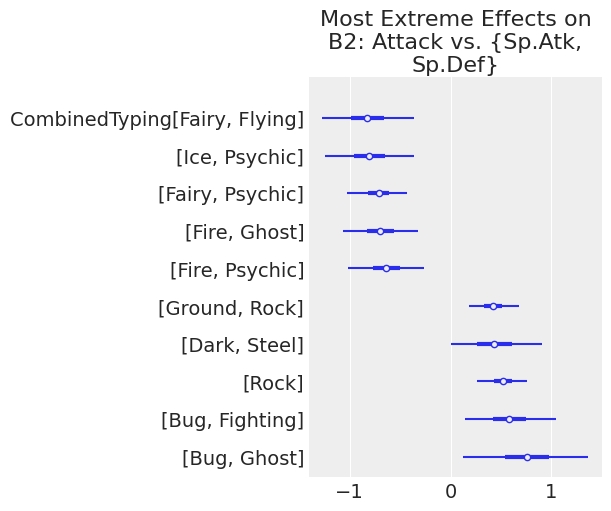

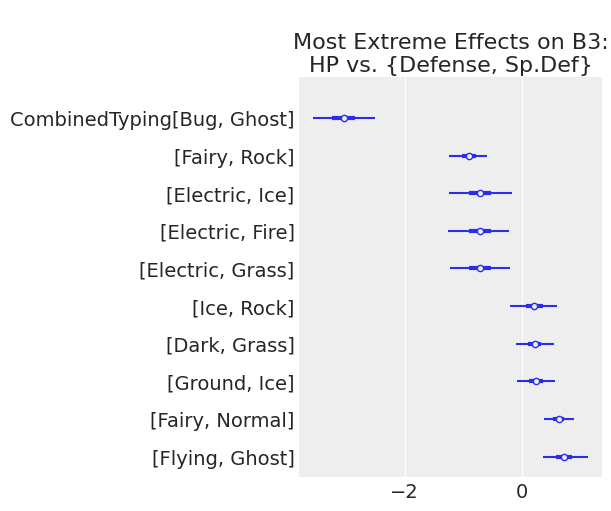

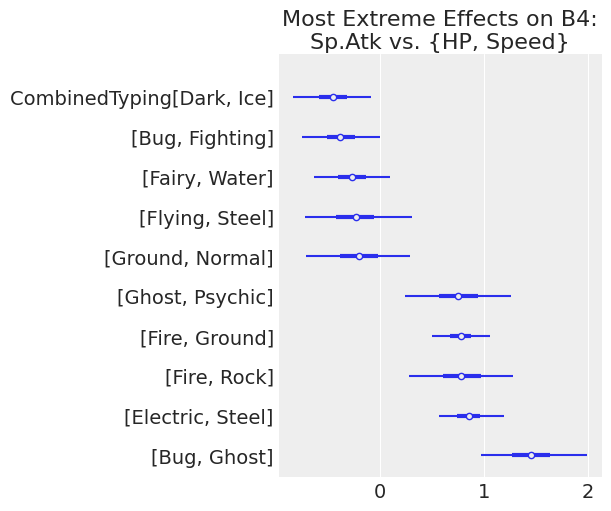

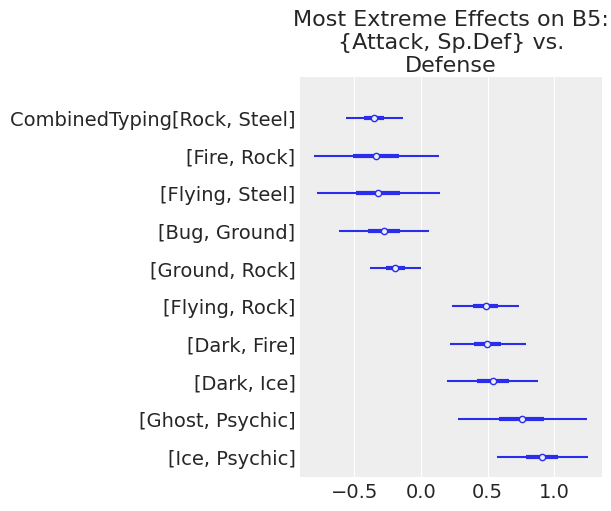

{'Grass, Steel': {'B1'}, 'Fire, Rock': {'B4', 'B1', 'B5'}, 'Rock, Steel': {'B5', 'B1'}, 'Rock': {'B2', 'B1'}, 'Ground, Steel': {'B1'}, 'Dark, Ice': {'B4', 'B1', 'B5'}, 'Bug, Water': {'B1'}, 'Ghost, Poison': {'B1'}, 'Electric, Normal': {'B1'}, 'Ice, Psychic': {'B5', 'B2', 'B1'}, 'Fairy, Flying': {'B2'}, 'Fairy, Psychic': {'B2'}, 'Fire, Ghost': {'B2'}, 'Fire, Psychic': {'B2'}, 'Ground, Rock': {'B5', 'B2'}, 'Dark, Steel': {'B2'}, 'Bug, Fighting': {'B4', 'B2'}, 'Bug, Ghost': {'B4', 'B2', 'B3'}, 'Fairy, Rock': {'B3'}, 'Electric, Ice': {'B3'}, 'Electric, Fire': {'B3'}, 'Electric, Grass': {'B3'}, 'Ice, Rock': {'B3'}, 'Dark, Grass': {'B3'}, 'Ground, Ice': {'B3'}, 'Fairy, Normal': {'B3'}, 'Flying, Ghost': {'B3'}, 'Fairy, Water': {'B4'}, 'Flying, Steel': {'B4', 'B5'}, 'Ground, Normal': {'B4'}, 'Ghost, Psychic': {'B4', 'B5'}, 'Fire, Ground': {'B4'}, 'Electric, Steel': {'B4'}, 'Bug, Ground': {'B5'}, 'Flying, Rock': {'B5'}, 'Dark, Fire': {'B5'}}


In [81]:
extreme_types = {}
for bal in balance_definitions.keys():
    model_b = models[bal]

    posterior_coeffs = model_b.posterior["CombinedTyping"]
    median_effects = posterior_coeffs.median(dim=("chain", "draw"))
    sorted_types = median_effects.to_series().sort_values()
    top_and_bottom_types = list(sorted_types.head(5).index) + list(sorted_types.tail(5).index)
    for n in top_and_bottom_types:
        extreme_types.setdefault(n, set()).add(bal)
    az.plot_forest(
        model_b,
        var_names=["CombinedTyping"],
        combined=True,
        coords={"CombinedTyping_dim": top_and_bottom_types}
    )
    plt.title(f"Most Extreme Effects on {bal}: {balance_definitions[bal]}")
    plt.show()
# extreme_types
print(extreme_types)

/var/folders/rm/0tp2_wjs4hl3t3t2bgrztxbr0000gp/T/ipykernel_54972/392447741.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


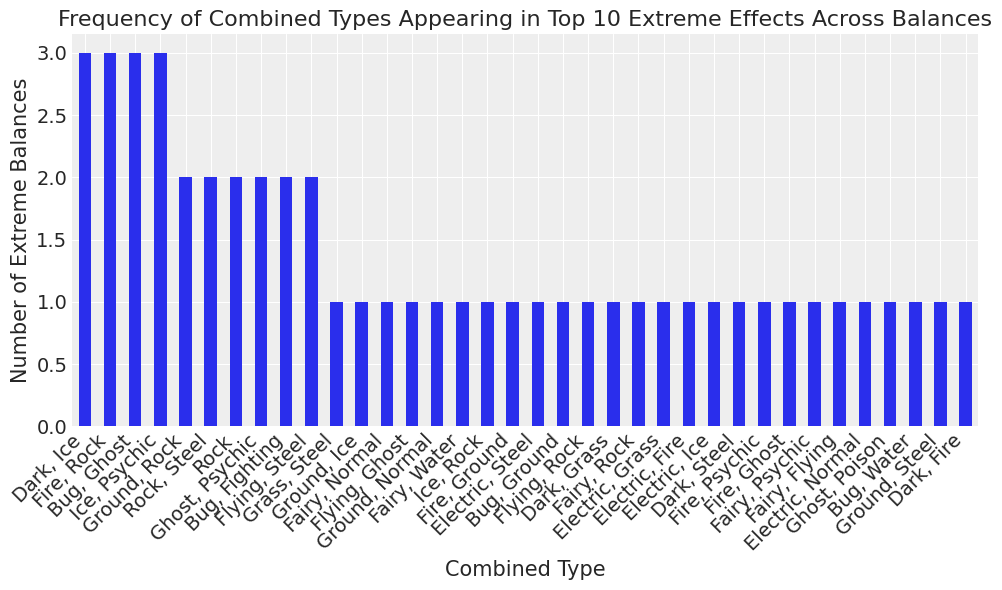

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))
type_counts = pd.Series({k: len(v) for k, v in extreme_types.items()})
type_counts = type_counts.sort_values(ascending=False)
type_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Combined Type')
ax.set_ylabel('Number of Extreme Balances')
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Combined Types Appearing in Top 10 Extreme Effects Across Balances')
plt.tight_layout()
plt.show()